In [113]:
using Pkg
Pkg.activate("..")

  Activating project at `~/Desktop/Continuous MPS/MatrixProductBP.jl`


In [114]:
using Revise
using TensorTrains, TensorCast, Tullio, CavityTools, Random, IterTools, Plots, JLD2
using MatrixProductBP
using Unzip: unzip

In [115]:
K = 100
scale = 5.0
P = 2.0
σ = 1/50
svd_trunc = TruncBond(1e10)
normalize=true;

In [116]:
μ = []
krange = 5:8

for k in krange
    filename="m_$k.jld2"
    data = load(filename)
    push!(μ, data["msg"])
end

@assert μ[2]==μ[1]
@assert μ[3]==μ[1]
@assert μ[4]==μ[1]

In [117]:
μ_fourier = [FourierTensorTrain_spin(μ[k], K, scale, P, σ) for k in 1:4]

@assert μ_fourier[2]==μ_fourier[1]
@assert μ_fourier[3]==μ_fourier[1]
@assert μ_fourier[4]==μ_fourier[1]

In [118]:
import MatrixProductBP: FourierMPEM2, FourierMPEM1

function Fourier3int_1(α::Int, γ::Int, w::Real, J::Float64, P::Float64)
    kαγ = 2π/P*(α-J*γ)
    iszero(kαγ) ? w : sin(kαγ*w)/kαγ
end

function convolution(F::Vector{FourierMPEM2{U1}}, J::Vector{U2}, P::Float64;
    K::Int=(size(F[1][1],3)-1)/2, scale::Real=1.0, svd_trunc=TruncThresh(1e-8), normalize::Bool=true) where {U1<:Number, U2<:Real}

    function op((F₁, J₁, d₁), (F₂, J₂, d₂))
        # display(svd_trunc)
        K1 = (size(F₁[1],3)-1)/2 |> Int
        K2 = (size(F₂[1],3)-1)/2 |> Int
        @tullio Int_1[γ,α] := Fourier3int_1(α,γ,1.0,J₁,P) α∈-K1:K1, γ∈-K:K
        @tullio Int_2[γ,β] := Fourier3int_1(β,γ,1.0,J₂,P) β∈-K2:K2, γ∈-K:K
    
        GG = map(zip(F₁,F₂)) do (F₁ᵗ, F₂ᵗ)
            @tullio Gt1[m1,n1,γ,x] := F₁ᵗ[m1,n1,α,x] * Int_1[γ,α]
            @tullio Gt2[m2,n2,γ,x] := F₂ᵗ[m2,n2,β,x] * Int_2[γ,β]
            @tullio Gt[m1,m2,n1,n2,γ,x] := 4/P * Gt1[m1,n1,γ,x] * Gt2[m2,n2,γ,x]
            @cast Gᵗ[(m1,m2),(n1,n2),γ,x] := Gt[m1,m2,n1,n2,γ,x]
            return collect(Gᵗ)
        end
    
        G = FourierTensorTrain(GG, z=F₁.z*F₂.z)
        G_ = deepcopy(G)
        compress!(G; svd_trunc)
        @show norm2m(G,G_)/(norm(G_)*norm(G))
        normalize && normalize_eachmatrix!(G)
        any(any(isnan, Gᵗ) for Gᵗ in G) && @error "NaN in Fourier tensor train"
        return (G, 1.0, d₁+d₂)
    end

    TTinit = [[1/2 for _ in 1:1, _ in 1:1, y in 1:2, x in 1:2] for _ in 1:length(F[1])] |> TensorTrain
    Ginit = (FourierTensorTrain_spin(TTinit, K, Inf, P, 0.0), 1.0, 0)
    G, full = cavity(zip(F,J,fill(1,length(F))) |> collect, op, Ginit)
    return G, full
end

convolution (generic function with 1 method)

In [119]:
dest, (conv_μ_full,) = convolution(μ_fourier, ones(4), P; K, scale, svd_trunc)
(conv_μ,) = unzip(dest)

@show conv_μ[1]≈conv_μ[2]
@show conv_μ[1]≈conv_μ[3]
@show conv_μ[1]≈conv_μ[4]
@show conv_μ[3]≈conv_μ[4]
;

norm2m(G, G_) / (norm(G_) * norm(G)) = 5.981004621107329e-16 - 5.383280815834846e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = -2.8431384040815263e-15 - 5.777686682449573e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = -3.6881128940248695e-15 + 5.794730253095167e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = 7.376225788049785e-16 - 7.047583283976366e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = -5.686276808163077e-15 + 9.217598273119344e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = -1.1356760379597275e-15 + 2.1749057421627094e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = -3.655463662390546e-15 - 4.6437583625707646e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = 3.2895525416090513e-15 - 3.5908650810454186e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = -1.2184878874635197e-15 + 6.305118838422395e-19im
norm2m(G, G_) / (norm(G_) * norm(G)) = -1.2184878874635197e-15 + 6.305118838422395e-19im
conv_μ[1] ≈ conv_μ[2] = true
conv_μ[1] ≈ conv_μ[3] = false
conv_μ[1] ≈ conv_μ[4] = false
conv_μ[3] ≈ conv_μ[4] = f

In [120]:
display(conv_μ[1][3][1,1,-3:3,:])
display(conv_μ[2][3][1,1,-3:3,:])
display(conv_μ[3][3][1,1,-3:3,:])
display(conv_μ[4][3][1,1,-3:3,:])

7×2 OffsetArray(::Matrix{ComplexF64}, 1:7, 1:2) with eltype ComplexF64 with indices 1:7×1:2:
  0.281993-0.0894723im    0.281993-0.0894723im
 -0.299196+0.0949307im   -0.299196+0.0949307im
 0.0292757-0.00928878im  0.0292757-0.00928878im
  0.686672-0.217871im     0.686672-0.217871im
 0.0292757-0.00928878im  0.0292757-0.00928878im
 -0.299196+0.0949307im   -0.299196+0.0949307im
  0.281993-0.0894723im    0.281993-0.0894723im

7×2 OffsetArray(::Matrix{ComplexF64}, 1:7, 1:2) with eltype ComplexF64 with indices 1:7×1:2:
  0.281993-0.0894723im    0.281993-0.0894723im
 -0.299196+0.0949307im   -0.299196+0.0949307im
 0.0292757-0.00928878im  0.0292757-0.00928878im
  0.686672-0.217871im     0.686672-0.217871im
 0.0292757-0.00928878im  0.0292757-0.00928878im
 -0.299196+0.0949307im   -0.299196+0.0949307im
  0.281993-0.0894723im    0.281993-0.0894723im

7×2 OffsetArray(::Matrix{ComplexF64}, 1:7, 1:2) with eltype ComplexF64 with indices 1:7×1:2:
  0.151704-0.0481334im    0.151704-0.0481334im
 -0.160959+0.0510698im   -0.160959+0.0510698im
 0.0157495-0.00499708im  0.0157495-0.00499708im
  0.369409-0.117208im     0.369409-0.117208im
 0.0157495-0.00499708im  0.0157495-0.00499708im
 -0.160959+0.0510698im   -0.160959+0.0510698im
  0.151704-0.0481334im    0.151704-0.0481334im

7×2 OffsetArray(::Matrix{ComplexF64}, 1:7, 1:2) with eltype ComplexF64 with indices 1:7×1:2:
  -0.199796+1.74379e-16im   -0.199796-4.40129e-17im
   0.211984-1.70916e-16im    0.211984+5.13488e-17im
 -0.0207422+2.30254e-16im  -0.0207422+4.62296e-17im
  -0.486516+3.0644e-16im    -0.486516-2.86327e-16im
 -0.0207422-3.00175e-16im  -0.0207422-1.52104e-16im
   0.211984-1.88487e-16im    0.211984+4.44093e-17im
  -0.199796+1.58716e-16im   -0.199796-9.66692e-17im

In [121]:
display(marginals_Fourier(marginalize(conv_μ[1]))[3][-3:3])
display(marginals_Fourier(marginalize(conv_μ[2]))[3][-3:3])
display(marginals_Fourier(marginalize(conv_μ[3]))[3][-3:3])
display(marginals_Fourier(marginalize(conv_μ[4]))[3][-3:3])

7-element Vector{ComplexF64}:
  0.22698258477449287 - 2.9772673164499706e-16im
 -0.24082991125356928 - 3.319694916907723e-16im
 0.023564724565622718 - 1.9500160153727042e-16im
   0.5527181031954147 + 4.560458436367993e-17im
 0.023564724565622638 + 1.460739658474059e-16im
 -0.24082991125356923 + 2.7677551203411754e-16im
  0.22698258477449296 + 3.2932213692325783e-16im

7-element Vector{ComplexF64}:
  0.22698258477449287 - 2.9772673164499706e-16im
 -0.24082991125356928 - 3.319694916907723e-16im
 0.023564724565622718 - 1.9500160153727042e-16im
   0.5527181031954147 + 4.560458436367993e-17im
 0.023564724565622638 + 1.460739658474059e-16im
 -0.24082991125356923 + 2.7677551203411754e-16im
  0.22698258477449296 + 3.2932213692325783e-16im

7-element Vector{ComplexF64}:
  0.22698258477449293 - 2.6298250950502057e-16im
 -0.24082991125356923 - 2.177905352608049e-16im
  0.02356472456562279 - 6.878008294595143e-17im
   0.5527181031954149 + 4.527828000242795e-18im
  0.02356472456562259 + 8.429155343907061e-17im
 -0.24082991125356926 + 2.8128747144875557e-16im
  0.22698258477449287 + 2.1128555601539616e-16im

7-element Vector{ComplexF64}:
  0.22698258477449293 - 1.9010264623685244e-16im
 -0.24082991125356926 - 4.687783996949453e-17im
  0.02356472456562278 - 2.2819143782511032e-17im
   0.5527181031954147 - 7.024493511164822e-18im
  0.02356472456562255 + 1.3761290327591883e-16im
  -0.2408299112535694 + 2.0570883945674998e-16im
  0.22698258477449285 + 7.992533656732459e-17im

In [122]:
function op((F₁, J₁, d₁), (F₂, J₂, d₂))
    K1 = (size(F₁[1],3)-1)/2 |> Int
    K2 = (size(F₂[1],3)-1)/2 |> Int
    @tullio Int_1[γ,α] := Fourier3int_1(α,γ,1.0,J₁,P) α∈axes(F₁[1],3), γ∈-K:K
    @tullio Int_2[γ,β] := Fourier3int_1(β,γ,1.0,J₂,P) β∈axes(F₂[1],3), γ∈-K:K

    GG = map(zip(F₁,F₂)) do (F₁ᵗ, F₂ᵗ)
        @tullio Gt1[m1,n1,γ,x] := F₁ᵗ[m1,n1,α,x] * Int_1[γ,α]
        @tullio Gt2[m2,n2,γ,x] := F₂ᵗ[m2,n2,β,x] * Int_2[γ,β]
        @tullio Gt[m1,m2,n1,n2,γ,x] := 4/P * Gt1[m1,n1,γ,x] * Gt2[m2,n2,γ,x]
        @cast Gᵗ[(m1,m2),(n1,n2),γ,x] := Gt[m1,m2,n1,n2,γ,x]
        return collect(Gᵗ)
    end

    G = FourierTensorTrain(GG, z=F₁.z*F₂.z)
    G_ = deepcopy(G)
    compress!(G; svd_trunc)
    @show norm2m(G,G_)/(norm(G_)*norm(G))
    normalize && normalize_eachmatrix!(G)
    any(any(isnan, Gᵗ) for Gᵗ in G) && @error "NaN in Fourier tensor train"
    return (G, 1.0, d₁+d₂)
end

op (generic function with 1 method)

In [123]:
TTinit = [[1/2 for _ in 1:1, _ in 1:1, y in 1:2, x in 1:2] for _ in 1:length(μ_fourier[1])] |> TensorTrain
Ginit = (FourierTensorTrain_spin(TTinit, K, Inf, P, 0.0), 1.0, 0)

μ4 = op((μ_fourier[4], 1.0, 1), Ginit)
(μ34,) = op((μ_fourier[3], 1.0, 1), μ4)
(μ_conv_1,) = op((μ_fourier[2], 1.0, 1), (μ34, 1.0, 2))

μ4 = op((μ_fourier[4], 1.0, 1), Ginit)
(μ34,) = op((μ_fourier[3], 1.0, 1), μ4)
(μ_conv_2,) = op((μ_fourier[1], 1.0, 1), (μ34, 1.0, 2))

(μ12,) = op((μ_fourier[1], 1.0, 1), (μ_fourier[2], 1.0, 1))
(μ4,) = op((μ_fourier[4], 1.0, 1), Ginit)
(μ_conv_3,) = op((μ12, 1.0, 2), (μ4, 1.0, 1))

μ12 = op((μ_fourier[1], 1.0, 1), (μ_fourier[2], 1.0, 1))
(μ123,) = op(μ12, (μ_fourier[3], 1.0, 1))
(μ_conv_4,) = op((μ123, 1.0, 3), Ginit)

@show μ_conv_1 ≈ μ_conv_2
@show μ_conv_1 ≈ μ_conv_3
@show μ_conv_1 ≈ μ_conv_4
@show μ_conv_3 ≈ μ_conv_4
;

norm2m(G, G_) / (norm(G_) * norm(G)) = -1.1356760379597275e-15 + 2.1749057421627094e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = 3.2895525416090513e-15 - 3.5908650810454186e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = -1.2184878874635197e-15 + 6.305118838422395e-19im
norm2m(G, G_) / (norm(G_) * norm(G)) = -1.1356760379597275e-15 + 2.1749057421627094e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = 3.2895525416090513e-15 - 3.5908650810454186e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = -1.2184878874635197e-15 + 6.305118838422395e-19im
norm2m(G, G_) / (norm(G_) * norm(G)) = 5.981004621107329e-16 - 5.383280815834846e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = -1.1356760379597275e-15 + 2.1749057421627094e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = -3.655463662390546e-15 - 4.6437583625707646e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = 5.981004621107329e-16 - 5.383280815834846e-18im
norm2m(G, G_) / (norm(G_) * norm(G)) = -2.8431384040815263e-15 - 5.777686682449573e-18im
norm2m(G, G_) / (norm(

In [124]:
display(μ_conv_1[3][1,1,-3:3,:])
display(μ_conv_2[3][1,1,-3:3,:])
display(μ_conv_3[3][1,1,-3:3,:])
display(μ_conv_4[3][1,1,-3:3,:])

7×2 OffsetArray(::Matrix{ComplexF64}, 1:7, 1:2) with eltype ComplexF64 with indices 1:7×1:2:
  0.281993-0.0894723im    0.281993-0.0894723im
 -0.299196+0.0949307im   -0.299196+0.0949307im
 0.0292757-0.00928878im  0.0292757-0.00928878im
  0.686672-0.217871im     0.686672-0.217871im
 0.0292757-0.00928878im  0.0292757-0.00928878im
 -0.299196+0.0949307im   -0.299196+0.0949307im
  0.281993-0.0894723im    0.281993-0.0894723im

7×2 OffsetArray(::Matrix{ComplexF64}, 1:7, 1:2) with eltype ComplexF64 with indices 1:7×1:2:
  0.281993-0.0894723im    0.281993-0.0894723im
 -0.299196+0.0949307im   -0.299196+0.0949307im
 0.0292757-0.00928878im  0.0292757-0.00928878im
  0.686672-0.217871im     0.686672-0.217871im
 0.0292757-0.00928878im  0.0292757-0.00928878im
 -0.299196+0.0949307im   -0.299196+0.0949307im
  0.281993-0.0894723im    0.281993-0.0894723im

7×2 OffsetArray(::Matrix{ComplexF64}, 1:7, 1:2) with eltype ComplexF64 with indices 1:7×1:2:
  0.151704-0.0481334im    0.151704-0.0481334im
 -0.160959+0.0510698im   -0.160959+0.0510698im
 0.0157495-0.00499708im  0.0157495-0.00499708im
  0.369409-0.117208im     0.369409-0.117208im
 0.0157495-0.00499708im  0.0157495-0.00499708im
 -0.160959+0.0510698im   -0.160959+0.0510698im
  0.151704-0.0481334im    0.151704-0.0481334im

7×2 OffsetArray(::Matrix{ComplexF64}, 1:7, 1:2) with eltype ComplexF64 with indices 1:7×1:2:
  -0.199796+1.74379e-16im   -0.199796-4.40129e-17im
   0.211984-1.70916e-16im    0.211984+5.13488e-17im
 -0.0207422+2.30254e-16im  -0.0207422+4.62296e-17im
  -0.486516+3.0644e-16im    -0.486516-2.86327e-16im
 -0.0207422-3.00175e-16im  -0.0207422-1.52104e-16im
   0.211984-1.88487e-16im    0.211984+4.44093e-17im
  -0.199796+1.58716e-16im   -0.199796-9.66692e-17im

In [125]:
display(marginals_Fourier(marginalize(μ_conv_1))[3][-3:3])
display(marginals_Fourier(marginalize(μ_conv_2))[3][-3:3])
display(marginals_Fourier(marginalize(μ_conv_3))[3][-3:3])
display(marginals_Fourier(marginalize(μ_conv_4))[3][-3:3])

7-element Vector{ComplexF64}:
  0.22698258477449287 - 2.9772673164499706e-16im
 -0.24082991125356928 - 3.319694916907723e-16im
 0.023564724565622718 - 1.9500160153727042e-16im
   0.5527181031954147 + 4.560458436367993e-17im
 0.023564724565622638 + 1.460739658474059e-16im
 -0.24082991125356923 + 2.7677551203411754e-16im
  0.22698258477449296 + 3.2932213692325783e-16im

7-element Vector{ComplexF64}:
  0.22698258477449287 - 2.9772673164499706e-16im
 -0.24082991125356928 - 3.319694916907723e-16im
 0.023564724565622718 - 1.9500160153727042e-16im
   0.5527181031954147 + 4.560458436367993e-17im
 0.023564724565622638 + 1.460739658474059e-16im
 -0.24082991125356923 + 2.7677551203411754e-16im
  0.22698258477449296 + 3.2932213692325783e-16im

7-element Vector{ComplexF64}:
  0.22698258477449293 - 2.6298250950502057e-16im
 -0.24082991125356923 - 2.177905352608049e-16im
  0.02356472456562279 - 6.878008294595143e-17im
   0.5527181031954149 + 4.527828000242795e-18im
  0.02356472456562259 + 8.429155343907061e-17im
 -0.24082991125356926 + 2.8128747144875557e-16im
  0.22698258477449287 + 2.1128555601539616e-16im

7-element Vector{ComplexF64}:
  0.22698258477449293 - 1.9010264623685244e-16im
 -0.24082991125356926 - 4.687783996949453e-17im
  0.02356472456562278 - 2.2819143782511032e-17im
   0.5527181031954147 - 7.024493511164822e-18im
  0.02356472456562255 + 1.3761290327591883e-16im
  -0.2408299112535694 + 2.0570883945674998e-16im
  0.22698258477449285 + 7.992533656732459e-17im

In [126]:
μ4 = op((μ_fourier[4], 1.0, 1), Ginit)
@show μ4[1] ≈ μ_fourier[4]

@show marginals_Fourier(marginalize(μ4[1])) ≈ marginals_Fourier(marginalize(μ_fourier[4]))
@show marginals_Fourier(marginalize(μ4[1]))[3][-5:5]
@show marginals_Fourier(marginalize(μ_fourier[4]))[3][-5:5]
;

norm2m(G, G_) / (norm(G_) * norm(G)) = -1.1356760379597275e-15 + 2.1749057421627094e-18im
μ4[1] ≈ μ_fourier[4] = false
marginals_Fourier(marginalize(μ4[1])) ≈ marginals_Fourier(marginalize(μ_fourier[4])) = true
((marginals_Fourier(marginalize(μ4[1])))[3])[-5:5] = ComplexF64[-0.28688762516594374 - 2.2041150379367365e-17im, -0.24049175578621385 + 3.3785078126369834e-17im, -0.09443361035567391 + 7.57150890540987e-17im, 0.09631617414238404 + 9.11941018745673e-17im, 0.25516322435375427 + 6.229473098660242e-17im, 0.31664669741723184 + 2.556724395170073e-17im, 0.2551632243537543 - 1.6803671195825953e-17im, 0.096316174142384 - 7.253199049524631e-17im, -0.09443361035567396 - 9.240535899251647e-17im, -0.2404917557862139 - 4.8999516059363124e-17im, -0.28688762516594374 - 2.2041150379367365e-17im]
((marginals_Fourier(marginalize(μ_fourier[4])))[3])[-5:5] = ComplexF64[-0.2868876251659438 + 9.342345750879592e-34im, -0.24049175578621387 + 4.646163649330846e-18im, -0.0944336103556739 + 7.7282973629688

In [127]:
display(μ4[1][3][:,:,-3:3,:])
display(μ_fourier[4][3][:,:,-3:3,:])

2×2×7×2 OffsetArray(::Array{ComplexF64, 4}, 1:2, 1:2, 1:7, 1:2) with eltype ComplexF64 with indices 1:2×1:2×1:7×1:2:
[:, :, 1, 1] =
  -0.284265+0.0901931im   0.283104-0.0937742im
 -0.0745716+0.695046im   0.0657923-0.695932im

[:, :, 2, 1] =
   0.289932-0.0919912im  -0.288747+0.0956436im
 -0.0760582+0.708902im   0.0671038-0.709806im

[:, :, 3, 1] =
   0.768094-0.243705im  -0.764957+0.253381im
 -0.0475666+0.443346im  0.0419666-0.443911im

[:, :, 4, 1] =
     0.953172-0.302428im       -0.949279+0.314436im
 -3.83103e-16-3.17969e-17im  2.89385e-17-6.55861e-18im

[:, :, 5, 1] =
  0.768094-0.243705im   -0.764957+0.253381im
 0.0475666-0.443346im  -0.0419666+0.443911im

[:, :, 6, 1] =
  0.289932-0.0919912im   -0.288747+0.0956436im
 0.0760582-0.708902im   -0.0671038+0.709806im

[:, :, 7, 1] =
 -0.284265+0.0901931im    0.283104-0.0937742im
 0.0745716-0.695046im   -0.0657923+0.695932im

[:, :, 1, 2] =
  -0.284265+0.0901931im   -0.283104+0.0937742im
 -0.0745716+0.695046im   -0.0657923+0.695932im

[

2×2×7×2 OffsetArray(::Array{ComplexF64, 4}, 1:2, 1:2, 1:7, 1:2) with eltype ComplexF64 with indices 1:2×1:2×1:7×1:2:
[:, :, 1, 1] =
    0.29823-2.23331e-16im      0.22713-2.23331e-16im
 1.6327e-16+0.917858im     1.81411e-17+0.699035im

[:, :, 2, 1] =
    -0.304176-2.27783e-16im     -0.231658-2.27783e-16im
 -1.66525e-16+0.936156im     -1.85028e-17+0.712971im

[:, :, 3, 1] =
    -0.805829-1.42455e-16im     -0.613715-1.42455e-16im
 -4.41163e-16+0.585469im     -4.90181e-17+0.44589im

[:, :, 4, 1] =
         -1.0+0.0im     -0.761594+0.0im
 -5.47464e-16-0.0im  -6.08293e-17-0.0im

[:, :, 5, 1] =
    -0.805829+1.42455e-16im     -0.613715+1.42455e-16im
 -4.41163e-16-0.585469im     -4.90181e-17-0.44589im

[:, :, 6, 1] =
    -0.304176+2.27783e-16im     -0.231658+2.27783e-16im
 -1.66525e-16-0.936156im     -1.85028e-17-0.712971im

[:, :, 7, 1] =
    0.29823+2.23331e-16im      0.22713+2.23331e-16im
 1.6327e-16-0.917858im     1.81411e-17-0.699035im

[:, :, 1, 2] =
     0.29823-3.34996e-16im      -0.2

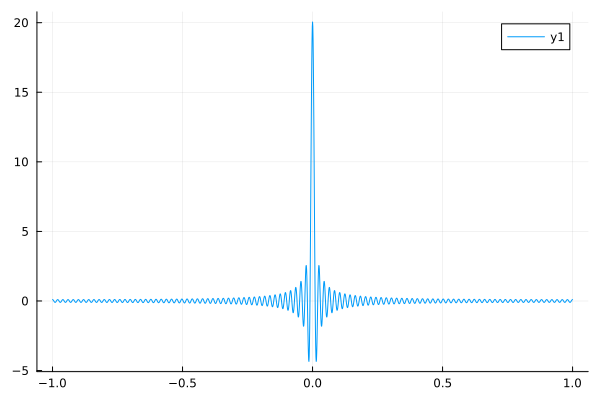

In [128]:
using Plots

delta_fourier = Ginit[1]
delta = marginals(marginalize(delta_fourier), 2.0)[3]

xplot = -1:0.001:1
yplot = delta.(xplot)
plot(xplot, yplot)